Liliana Djaja Witama\
2702219774

# UAS Machine Learning
## No 1
Video: https://drive.google.com/file/d/1h86bVj7dCDs_9bukQgi_lR2Ox04EGFQ4/view?usp=sharing

### variables
ID: the individual’s patient ID\
Registration Date: the individual’s registration date at the hospital\
Drug: type of drug given to the individual (D-penicillamine or placebo)\
Birth Date: the birth date of the individual\
Gender: the gender of the individual\
Ascites: presence of ascites (Y/N)\
Hepatomegaly: presence of hepatomegaly (Y/N)\
Edema: presence of edema (N = no edema, S = edema without diuretics, Y = edema despite diuretic therapy)\
Bilirubin: serum bilirubin (mg/dL)\
Cholesterol: serum cholesterol (mg/dL)\
Albumin: amount of albumin (g/dL)\
Copper: amount of copper found in urine (μg/day)\
Alkaline Phospatase (U/L): alkaline phosphatase (U/L)\
SGOT: Serum Glutamic-Oxaloacetic Transaminase (U/mL)\
Tryglicerides: Amount of triglycerides (mg/dL)\
Platelets: Platelets per cubic (mL/1000)\
Prothrombin: Prothrombin time (s)\
Stage: Histologic stage of the cirrhosis

## Importing Libraries and Dataset

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm as tqdm
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from datetime import datetime

from imblearn.over_sampling import RandomOverSampler, SMOTE
import random
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

In [59]:
df = pd.read_csv('1A.tsv', sep='\t')
df.head()

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


## EDA

### Dataframe information

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT                       312 non-null    float64

There are 418 rows and 18 columns

### Removing unnecessary variables

In [61]:
df = df.drop(['ID', 'Registration Date'], axis=1)

### Look for null and duplicated values

In [62]:
df.duplicated().sum()

0

In [63]:
df.isna().sum()

Drug                         106
Birth Date                     0
Gender                         0
Ascites                      106
Hepatomegaly                 106
Edema                          0
Bilirubin                      0
Cholesterol                  338
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                  0
Platelets                     11
Prothrombin                    2
Stage                          6
dtype: int64

80% of the values in variable Cholesterol is null. since this dataset is medical, i will not do imputation as there will be too much synthetic data. hence, i will drop the column.

In [64]:
df.drop('Cholesterol', axis=1, inplace=True)

#### Look at the pattern of the null values

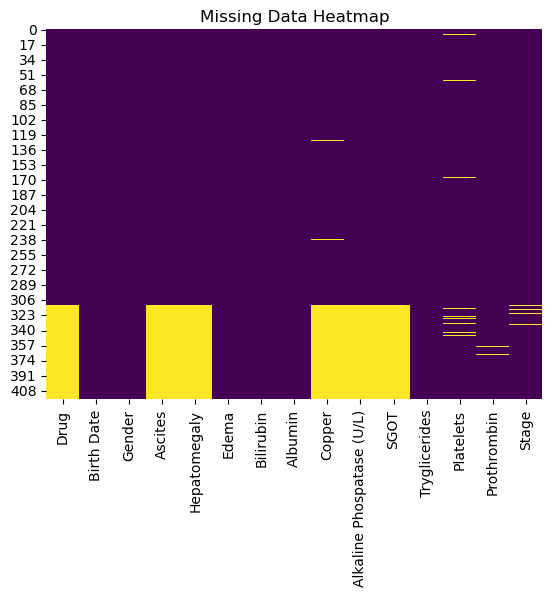

In [65]:
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

Calculate missing values count per stage for each variable

In [66]:
variables = ['Drug', 'Ascites', 'Hepatomegaly', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT']
for i in variables:
    missing_counts = df[i].isnull().groupby(df['Stage']).sum()
    print(i)
    print(missing_counts, '\n')

Drug
Stage
Stage 1     5
Stage 2    25
Stage4     35
stage_3    35
Name: Drug, dtype: int64 

Ascites
Stage
Stage 1     5
Stage 2    25
Stage4     35
stage_3    35
Name: Ascites, dtype: int64 

Hepatomegaly
Stage
Stage 1     5
Stage 2    25
Stage4     35
stage_3    35
Name: Hepatomegaly, dtype: int64 

Copper
Stage
Stage 1     5
Stage 2    26
Stage4     36
stage_3    35
Name: Copper, dtype: int64 

Alkaline Phospatase (U/L)
Stage
Stage 1     5
Stage 2    25
Stage4     35
stage_3    35
Name: Alkaline Phospatase (U/L), dtype: int64 

SGOT
Stage
Stage 1     5
Stage 2    25
Stage4     35
stage_3    35
Name: SGOT, dtype: int64 



there is pattern found in null values for variables 'Drug', 'Ascites', 'Hepatomegaly', 'Copper', 'Alkaline Phospatase (U/L)', and 'SGOT', where there are more null values in Stage 3 and Stage 4. Hence, they are missing at random (MAR).\
however, the rest of the null values are missing completely at random (MCAR) because we don't see any pattern.

### separating numerical and categorical columns

In [67]:
num_cols = []
cat_cols = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print('numerical: ', num_cols)
print('categorical: ', cat_cols)

numerical:  ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical:  ['Drug', 'Birth Date', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']


### Feature engineering
generate a new feature 'Age' from 'Birth Date' for analysis purposes

In [68]:
df['Birth Date'] = pd.to_datetime(df['Birth Date'])
current_date = datetime(2025, 1, 1)
df['Age'] = df['Birth Date'].apply(lambda x: (current_date - x).days // 365)

In [69]:
df.drop(columns=['Birth Date'], inplace=True)
num_cols.append('Age')
cat_cols.remove('Birth Date')

### Numerical variables description

In [70]:
df[num_cols].describe()

,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age
count,418.000000,418.000000,310.000000,312.000000,312.000000,418.000000,407.000000,416.000000,418.000000
mean,3.220813,3.497440,97.648387,1982.655769,122.556346,83.803828,257.024570,10.731731,50.440191
std,4.407506,0.424972,85.613920,2140.388824,56.699525,79.603693,98.325585,1.022000,10.488432
min,0.300000,1.960000,4.000000,289.000000,26.350000,-1.000000,62.000000,9.000000,26.000000
25%,0.800000,3.242500,41.250000,871.500000,80.600000,-1.000000,188.500000,10.000000,42.250000
50%,1.400000,3.530000,73.000000,1259.000000,114.700000,85.000000,251.000000,10.600000,51.000000
75%,3.400000,3.770000,123.000000,1980.000000,151.900000,127.750000,318.000000,11.100000,58.000000
max,28.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,78.000000


In [71]:
(df['Tryglicerides'] < 0).sum()

136

an anomaly is found in variable Tryglicerides. 28% of Tryglicerides value is negative when logically it shouldn't be. hence, i will treat negative values as missing values.

In [72]:
df['Tryglicerides'] = df['Tryglicerides'].apply(lambda x: np.nan if x < 0 else x)

### unique values in categorical variables

In [73]:
for i in cat_cols:
    print(df[i].value_counts(), '\n')

Drug
D-penicillamine    155
Placebo            152
d-penicillamine      3
placebo              1
lacebo               1
Name: count, dtype: int64 

Gender
F    374
M     44
Name: count, dtype: int64 

Ascites
N    288
Y     24
Name: count, dtype: int64 

Hepatomegaly
Y    160
N    152
Name: count, dtype: int64 

Edema
N    354
S     44
Y     20
Name: count, dtype: int64 

Stage
stage_3    155
Stage4     144
Stage 2     92
Stage 1     21
Name: count, dtype: int64 



the target variable (Stage) is not very balanced, with Stage 1 only having 21 entries.

### Handling inconsistent data

#### Variable Drug

In [74]:
df['Drug'] = df['Drug'].str.replace(r'\b(placebo|lacebo)\b', 'Placebo', case=False, regex=True)
df['Drug'] = df['Drug'].str.replace(r'\bd-penicillamine\b', 'D-penicillamine', case=False, regex=True)

#### Variable Stage

In [75]:
df['Stage'] = df['Stage'].str.replace(r'\bStage_3\b', 'Stage 3', case=False, regex=True)
df['Stage'] = df['Stage'].str.replace(r'\bStage4\b', 'Stage 4', case=False, regex=True)

### looking at outliers and distribution

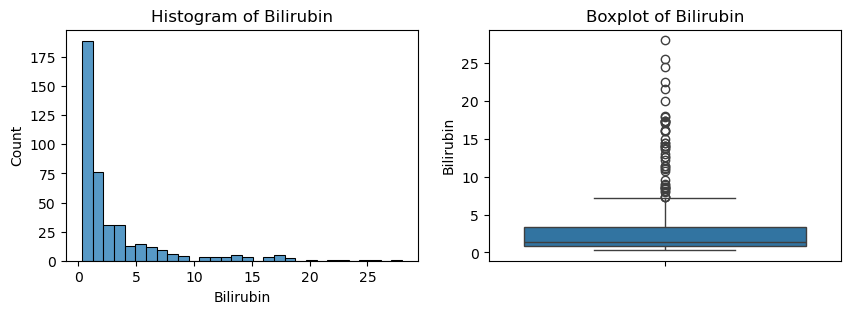

skewness: 2.717610708740455
kurtosis: 8.065335678744502


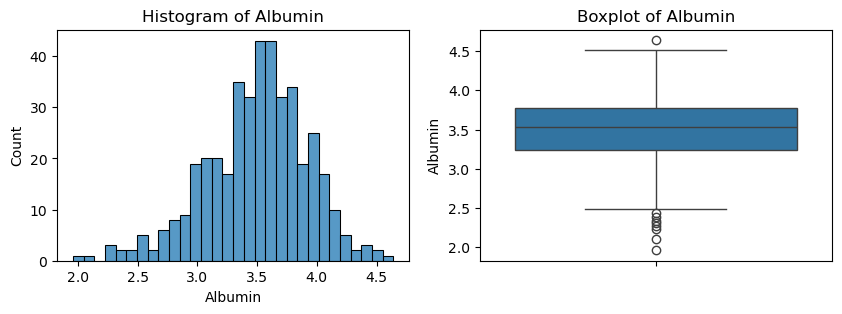

skewness: -0.4675265141762801
kurtosis: 0.5667445291024173


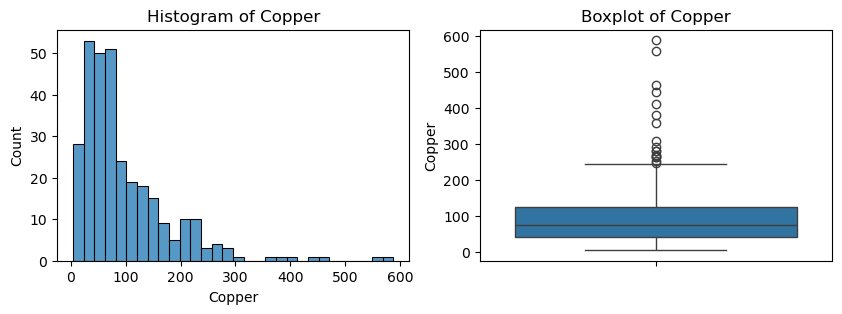

skewness: 2.3036399957832616
kurtosis: 7.624023449861701


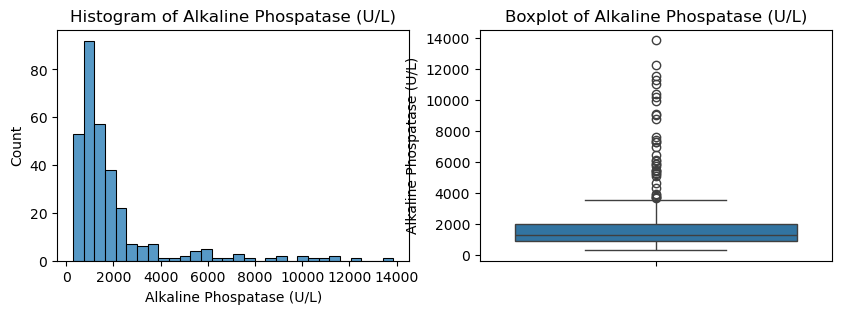

skewness: 2.9928343153496115
kurtosis: 9.662553460966153


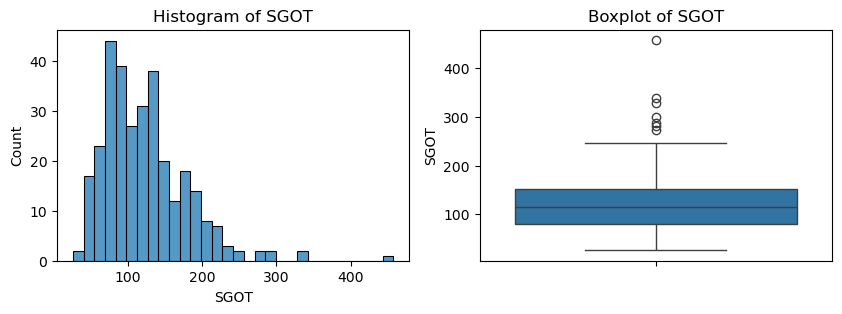

skewness: 1.4491969235882083
kurtosis: 4.311975857605217


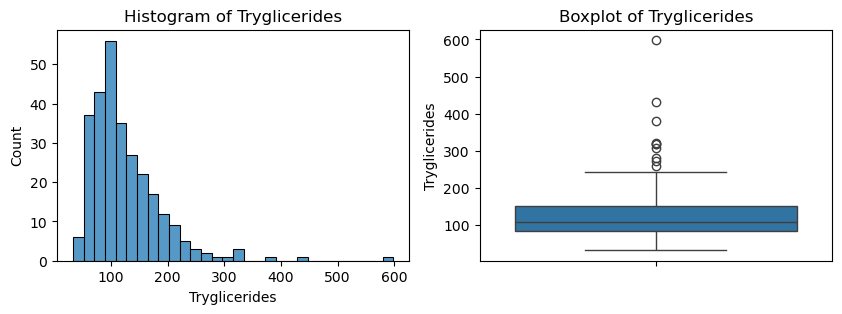

skewness: 2.5239024664577845
kurtosis: 11.802753128498216


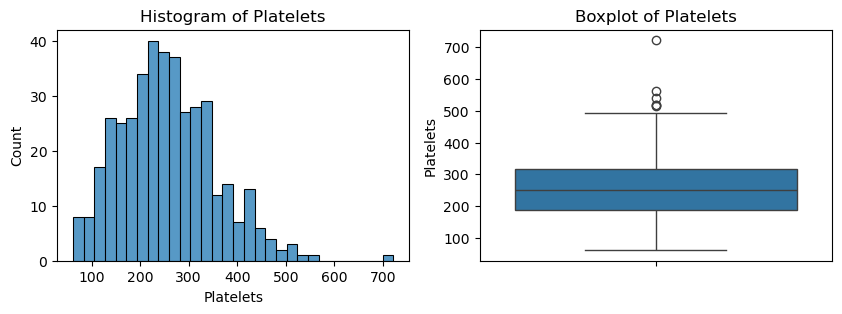

skewness: 0.6270977603715678
kurtosis: 0.8630445578915271


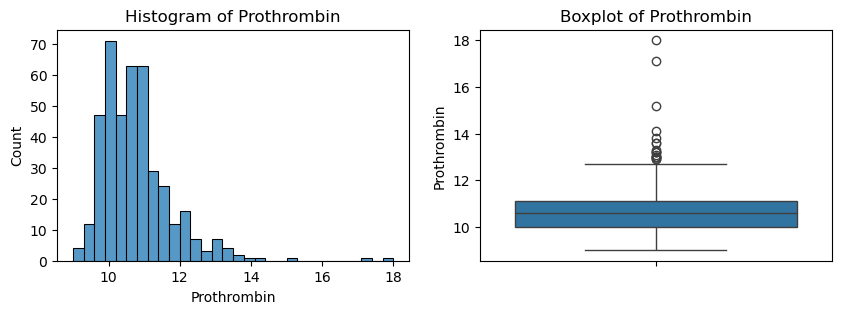

skewness: 2.223276154109735
kurtosis: 10.040772735082795


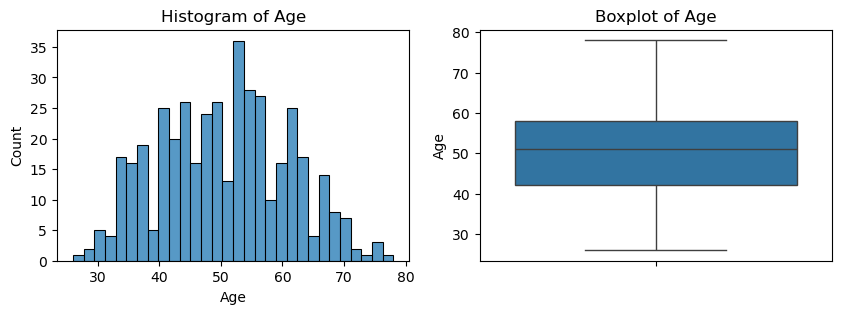

skewness: 0.08122576408365573
kurtosis: -0.6222523828461064


In [76]:
def look_outliers_distribution(df, numerical):
    for col in numerical:
        plt.figure(figsize=(10,3))

        plt.subplot(1,2,1) #,1 = left
        sns.histplot(df[col], bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(1,2,2) #,2 = right side
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print(f'skewness: {df[col].skew()}')
        print(f'kurtosis: {df[col].kurt()}')


look_outliers_distribution(df[num_cols], num_cols)

the numerical variables are mostly skewed. however, i will not do any transformation because the models used (random forest and XGBoost) are tree-based which are not significantly affected by skewed variables. there are also outliers found in all numerical variables except Age. however, i will not drop them to preserve the information of the data.

### MAR null values handling: stage-specific imputation

In [77]:
cat_var = ['Drug', 'Ascites', 'Hepatomegaly']
num_var = ['Copper', 'Alkaline Phospatase (U/L)', 'SGOT']

for i in cat_var:
    df[i] = df.groupby('Stage')[i].transform(lambda x: x.fillna(x.mode()[0]))

for i in num_var:
    df[i] = df.groupby('Stage')[i].transform(lambda x: x.fillna(x.median()))

### Fill in Tryglicerides using KNN


In [78]:
imputer = KNNImputer(n_neighbors=5)
missing_rows = df['Tryglicerides'].isna()
imputed_values = imputer.fit_transform(df[['Tryglicerides']])[missing_rows]
df.loc[missing_rows, 'Tryglicerides'] = imputed_values

In [79]:
df[num_cols].describe()

,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age
count,418.000000,418.000000,412.000000,412.000000,412.000000,418.000000,407.000000,416.000000,418.000000
mean,3.220813,3.497440,91.714806,1808.764806,120.122767,124.702128,257.024570,10.731731,50.440191
std,4.407506,0.424972,75.586269,1888.878700,49.887867,53.479887,98.325585,1.022000,10.488432
min,0.300000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,26.000000
25%,0.800000,3.242500,49.500000,982.000000,88.350000,95.000000,188.500000,10.000000,42.250000
50%,1.400000,3.530000,67.500000,1257.500000,112.375000,124.702128,251.000000,10.600000,51.000000
75%,3.400000,3.770000,102.000000,1716.500000,136.485000,127.750000,318.000000,11.100000,58.000000
max,28.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,78.000000


### MCAR null values handling: row removal

In [80]:
df = df.dropna()

### Dataset information after data cleaning

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399 entries, 0 to 417
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       399 non-null    object 
 1   Gender                     399 non-null    object 
 2   Ascites                    399 non-null    object 
 3   Hepatomegaly               399 non-null    object 
 4   Edema                      399 non-null    object 
 5   Bilirubin                  399 non-null    float64
 6   Albumin                    399 non-null    float64
 7   Copper                     399 non-null    float64
 8   Alkaline Phospatase (U/L)  399 non-null    float64
 9   SGOT                       399 non-null    float64
 10  Tryglicerides              399 non-null    float64
 11  Platelets                  399 non-null    float64
 12  Prothrombin                399 non-null    float64
 13  Stage                      399 non-null    object 
 14 

The dataset now consists of 399 rows and 15 columns

In [82]:
df[num_cols].describe()

,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age
count,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000,399.000000
mean,3.234085,3.496667,92.687970,1818.837343,120.831190,124.641497,255.363409,10.715539,50.270677
std,4.438484,0.421915,76.509752,1904.532353,50.367874,54.382751,95.411306,0.961500,10.510914
min,0.300000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,26.000000
25%,0.800000,3.255000,49.500000,981.000000,88.350000,93.000000,188.500000,10.000000,42.000000
50%,1.400000,3.520000,67.500000,1257.500000,112.375000,124.702128,249.000000,10.600000,51.000000
75%,3.400000,3.770000,103.000000,1763.000000,137.950000,130.500000,316.500000,11.100000,58.000000
max,28.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,78.000000


### Check distribution after data cleaning

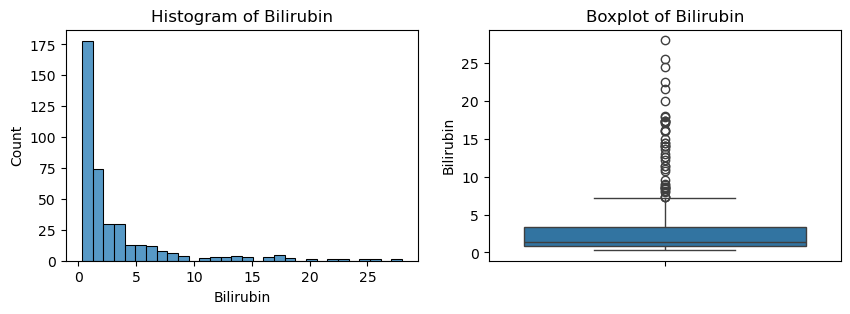

skewness: 2.734220426095142
kurtosis: 8.135582066375838


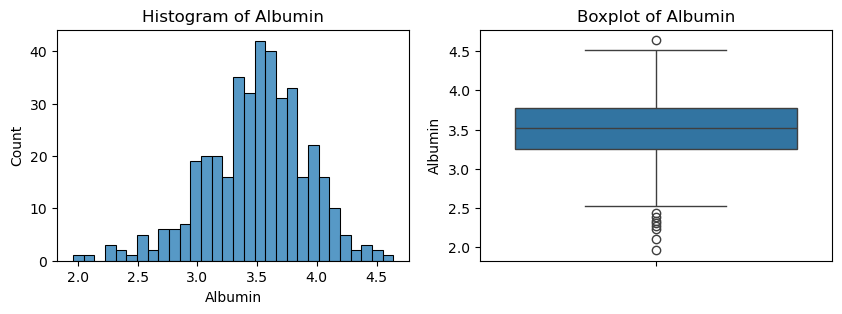

skewness: -0.4490024746316969
kurtosis: 0.6733584179750531


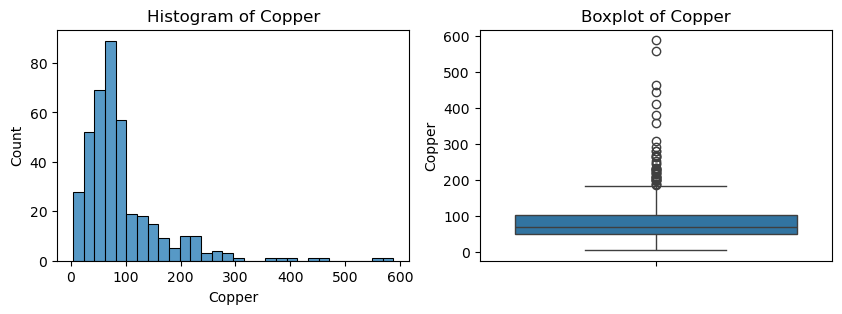

skewness: 2.681910841452291
kurtosis: 10.574326314137188


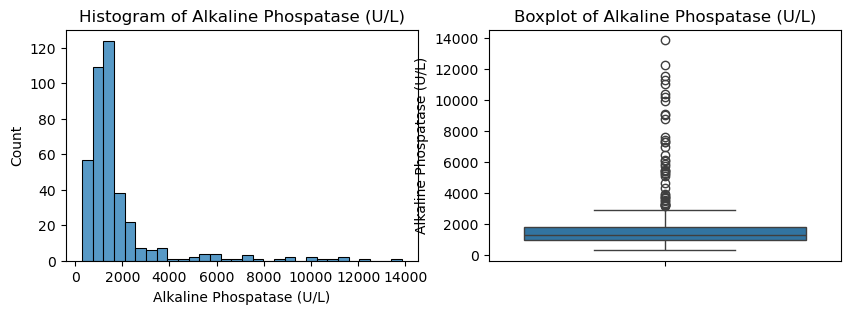

skewness: 3.5403805095790517
kurtosis: 13.876610686353166


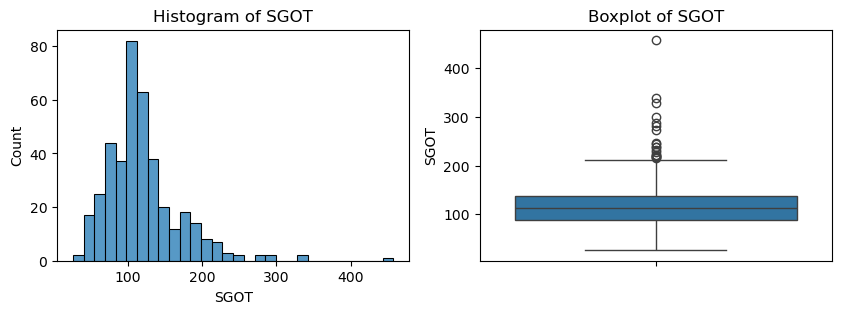

skewness: 1.7109371456021338
kurtosis: 6.383533302476842


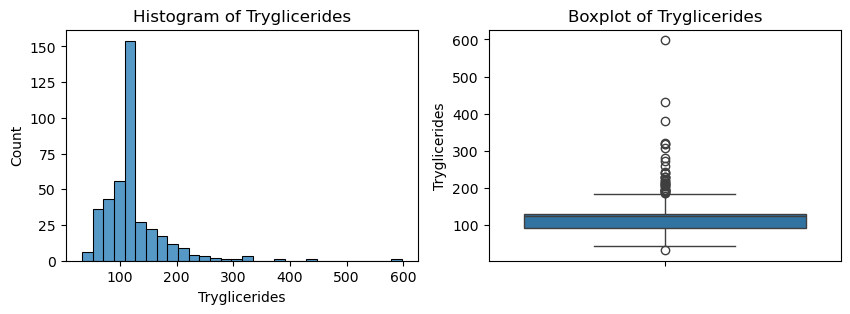

skewness: 3.044879828108449
kurtosis: 18.385010113592877


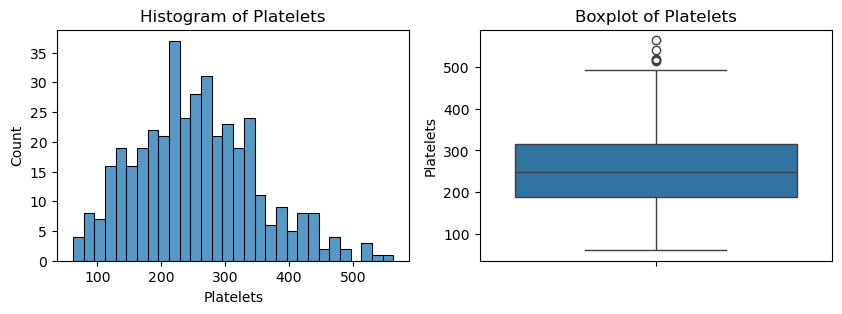

skewness: 0.44758069703889974
kurtosis: 0.0037421016387217954


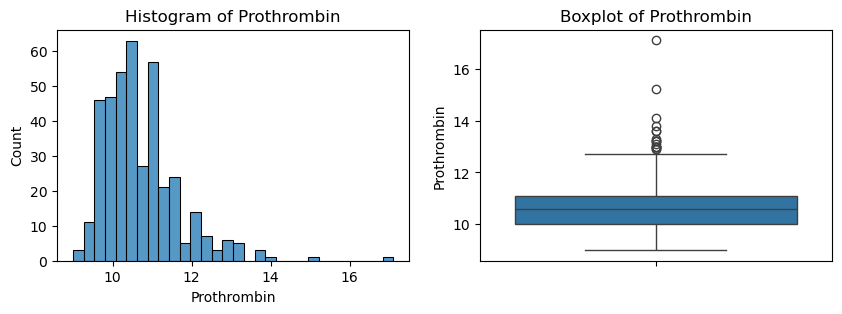

skewness: 1.747910788214909
kurtosis: 6.099490553711112


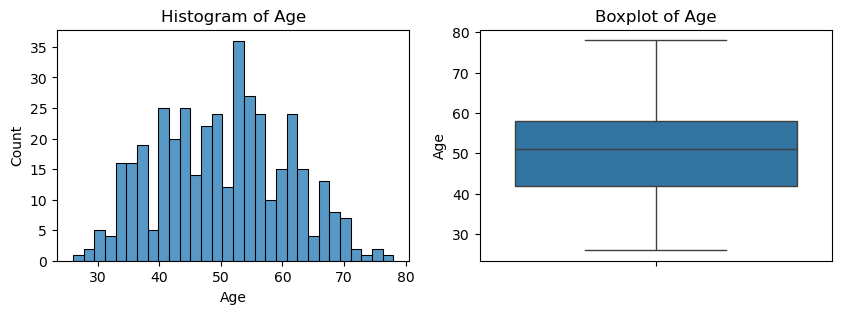

skewness: 0.08735011911056313
kurtosis: -0.6468520383412177


In [83]:
def look_outliers_distribution(df, numerical):
    for col in numerical:
        plt.figure(figsize=(10,3))

        plt.subplot(1,2,1)
        sns.histplot(df[col], bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(1,2,2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print(f'skewness: {df[col].skew()}')
        print(f'kurtosis: {df[col].kurt()}')


look_outliers_distribution(df[num_cols], num_cols)

tehre is a slight change in the skewness of the numerical variables, but mostly are still skewed.

### looking at the distribution using shapiro wilk test

In [84]:
for i in num_cols:
    print(i, shapiro(df[i]))

Bilirubin ShapiroResult(statistic=0.6299509906745123, pvalue=2.0113742462018245e-28)
Albumin ShapiroResult(statistic=0.9866564411899302, pvalue=0.0009998091535424296)
Copper ShapiroResult(statistic=0.7565136457644487, pvalue=7.658326553450019e-24)
Alkaline Phospatase (U/L) ShapiroResult(statistic=0.5545845762521491, pvalue=1.3753109609887774e-30)
SGOT ShapiroResult(statistic=0.8910124333107444, pvalue=3.0563738195811256e-16)
Tryglicerides ShapiroResult(statistic=0.7716937481255568, pvalue=3.554059623793319e-23)
Platelets ShapiroResult(statistic=0.9840239218006354, pvalue=0.00021684841508546948)
Prothrombin ShapiroResult(statistic=0.8843367706987769, pvalue=9.47945575483459e-17)
Age ShapiroResult(statistic=0.989150195016699, pvalue=0.004687500327902611)


the p-value of all variables are way less than 0.05, so they are not normally distributed

In [85]:
df.reset_index(drop=True, inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       399 non-null    object 
 1   Gender                     399 non-null    object 
 2   Ascites                    399 non-null    object 
 3   Hepatomegaly               399 non-null    object 
 4   Edema                      399 non-null    object 
 5   Bilirubin                  399 non-null    float64
 6   Albumin                    399 non-null    float64
 7   Copper                     399 non-null    float64
 8   Alkaline Phospatase (U/L)  399 non-null    float64
 9   SGOT                       399 non-null    float64
 10  Tryglicerides              399 non-null    float64
 11  Platelets                  399 non-null    float64
 12  Prothrombin                399 non-null    float64
 13  Stage                      399 non-null    object 

## Conclusion
Originally, there were 418 rows and 18 columns in this dataset. There was no duplicated data. Then, I dropped the 'ID' column because it's the id variable and 'Registration Date'. I did feature engineering where I generated the variable Age from 'Birth Date' for analysis purposes. There were around 80% of null values found in variable 'Cholesterol', so I dropped the column. I then did stage specific imputation for variables 'Drug', 'Ascites', 'Hepatomegaly', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT' because pattern was found in them. For null variables found in other variables, I just dropped the rows because the amount was insignificant. Anomalies were found in variable Drug and Stage where there were some inconsistencies, which then I made uniform. An anomaly was found in variable Tryglicerides where 28% of Tryglicerides value are negative when logically it shouldn't be. Hence, i treated those negative values as missing values which I did imputation using KNNImputer as to be careful as this is medical data. After EDA and data cleaning, the dataset now has 399 rows and 15 columns. There are now 9 numerical variables ('Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age') and 6 categorical variables ('Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage'). The distribution of numerical variables slightly changed but are still skewed. There are outliers found in the numerical variables which I kept so that I can keep the important data. They are also not normally distributed.

## Preprocessing

### Splitting the dataset into train and test set

In [88]:
input_df = df.drop('Stage', axis=1)
output_df = df['Stage']

x_train, x_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.2, random_state=42)

### Encoding

In [89]:
binary = {'N': 0, 'Y': 1}
bin_encoded = ['Ascites', 'Hepatomegaly']
for col in bin_encoded:
    x_train[col] = x_train[col].map(binary)
    x_test[col] = x_test[col].map(binary)

gender = {'F': 0, 'M': 1}
x_train['Gender'] = x_train['Gender'].map(gender)
x_test['Gender'] = x_test['Gender'].map(gender)

In [90]:
lb_encoder = LabelEncoder()
x_train['Drug'] = lb_encoder.fit_transform(x_train[['Drug']])
x_test['Drug'] = lb_encoder.transform(x_test[['Drug']])

c:\Users\lenovo\Documents\anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\lenovo\Documents\anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [91]:
ord_edema = OrdinalEncoder(categories=[['N', 'S', 'Y']])
x_train['Edema'] = ord_edema.fit_transform(x_train['Edema'].values.reshape(-1, 1))
x_test['Edema'] = ord_edema.transform(x_test['Edema'].values.reshape(-1, 1))

### Encoding 'Stage' for XGBoost

In [92]:
ord = OrdinalEncoder(categories=[['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']])
y_train_xg = ord.fit_transform(y_train.values.reshape(-1, 1))
y_test_xg = ord.transform(y_test.values.reshape(-1, 1))

### Oversampling: SMOTE
Oversampling is done because the target variable 'Stage' is imbalanced.

In [93]:
ros = SMOTE(random_state=SEED, sampling_strategy='minority')
x_train_smote, y_train_smote = ros.fit_resample(x_train, y_train)

In [94]:
x_train_xg_smote, y_train_xg_smote = ros.fit_resample(x_train, y_train_xg)

## Modelling and Evaluation

### Metrics used to evaluate the models: precision, recall, f1-score
There are 2 cases which could cost the the patient greatly:
1. patients were wrongly identified as having a certain stage, leading to over-diagnosis (false positive) -> they wouldn't get the right treatment according to their disease stage
2. the doctor/diagnosis missed many actual cases of that stage (false negative) -> could delay the treatment 

To avoid these situations, we want to achieve a balanced score of precision and recall. Hence, i will also use f1-score as the evaluation metric as f1-score is the harmonic mean of precision and recall.

### Random Forest

In [95]:
randomForest = RandomForestClassifier(n_estimators=100, random_state=42)
randomForest.fit(x_train_smote, y_train_smote)
y_pred_randomForest = randomForest.predict(x_test)

In [96]:
print(classification_report(y_test, y_pred_randomForest))

              precision    recall  f1-score   support

     Stage 1       0.25      0.33      0.29         3
     Stage 2       0.40      0.43      0.41        14
     Stage 3       0.68      0.50      0.58        34
     Stage 4       0.78      0.97      0.86        29

    accuracy                           0.65        80
   macro avg       0.53      0.56      0.53        80
weighted avg       0.65      0.65      0.64        80



**Stage 1**\
Stage 1 has a precision score of 0.25 meaning 25% of patients predicted as Stage 1 actually belong to Stage 1. A recall score of 0.33 means that 33% of actual Stage 1 patients were identified correctly, while the others were missed. An f1-score of 0.29 means that the model has a poor balance between identifying Stage 1 patients correctly and avoiding over-prediction.

**Stage 2**\
Stage 2 has a precision score of 0.40 meaning 40% of patients predicted as Stage 2 actually belong to Stage 2. A recall score of 0.43 means that 43% of actual Stage 2 patients were identified correctly, while the others were missed. An f1-score of 0.41 means that the model has a poor balance between identifying Stage 2 patients correctly and avoiding over-prediction.

**Stage 3**\
Stage 3 has a precision score of 0.68 meaning 68% of patients predicted as Stage 3 actually belong to Stage 3. A recall score of 0.50 means that 50% of actual Stage 3 patients were identified correctly, while the others were missed. An f1-score of 0.58 means that the model has a moderate balance between identifying Stage 3 patients correctly and avoiding over-prediction.

**Stage 4**\
Stage 4 has a precision score of 0.78 meaning 78% of patients predicted as Stage 4 actually belong to Stage 4. A recall score of 0.97 means that 97% of actual Stage 4 patients were identified correctly, while the others were missed. An f1-score of 0.86 means that the model has a good balance between identifying Stage 4 patients correctly and avoiding over-prediction.

**Overall**\
The model has an overall accuracy of 65%. This means, the model has moderate performance, with better predictions for Stage 4 and weaker predictions for Stage 1.

### XG Boost

In [97]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=10,                         
    objective='multi:softmax',
    num_class=4,               
    random_state=42
)

In [98]:
xgb_clf.fit(x_train_xg_smote, y_train_xg_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [99]:
y_pred_xg = xgb_clf.predict(x_test)

In [101]:
#inverse encoding first
y_test_xg_decoded = ord.inverse_transform(y_test_xg)
y_pred_xg_decoded = ord.inverse_transform(y_pred_xg.reshape(-1, 1))

print(classification_report(y_test_xg_decoded, y_pred_xg_decoded))

              precision    recall  f1-score   support

     Stage 1       0.14      0.33      0.20         3
     Stage 2       0.55      0.43      0.48        14
     Stage 3       0.62      0.44      0.52        34
     Stage 4       0.68      0.90      0.78        29

    accuracy                           0.60        80
   macro avg       0.50      0.52      0.49        80
weighted avg       0.61      0.60      0.59        80



**Stage 1**\
Stage 1 has a precision score of 0.14 meaning 14% of patients predicted as Stage 1 actually belong to Stage 1. A recall score of 0.33 means that 33% of actual Stage 1 patients were identified correctly, while the others were missed. An f1-score of 0.20 means that the model has a poor balance between identifying Stage 1 patients correctly and avoiding over-prediction.

**Stage 2**\
Stage 2 has a precision score of 0.55 meaning 55% of patients predicted as Stage 2 actually belong to Stage 2. A recall score of 0.43 means that 43% of actual Stage 2 patients were identified correctly, while the others were missed. An f1-score of 0.48 means that the model has a poor balance between identifying Stage 2 patients correctly and avoiding over-prediction.

**Stage 3**\
Stage 3 has a precision score of 0.62 meaning 62% of patients predicted as Stage 3 actually belong to Stage 3. A recall score of 0.44 means that 44% of actual Stage 3 patients were identified correctly, while the others were missed. An f1-score of 0.52 means that the model has a moderate balance between identifying Stage 3 patients correctly and avoiding over-prediction.

**Stage 4**\
Stage 4 has a precision score of 0.68 meaning 68% of patients predicted as Stage 4 actually belong to Stage 4. A recall score of 0.90 means that 90% of actual Stage 4 patients were identified correctly, while the others were missed. An f1-score of 0.78 means that the model has a good balance between identifying Stage 4 patients correctly and avoiding over-prediction.

**Overall**\
The model has an overall accuracy of 60%. This means, the model has moderate performance, with better predictions for Stage 4 and weaker predictions for Stage 1.

## Fine-tuning

### Random forest

In [102]:
parameter = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'max_features': [3, 5, 10],
}

In [103]:
grid_search = GridSearchCV(estimator=randomForest, 
                           param_grid=parameter, 
                           scoring='recall', 
                           cv=5,              
                           n_jobs=-1,          
                           verbose=1)          

In [104]:
grid_search.fit(x_train_smote, y_train_smote)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\lenovo\Documents\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [3, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='recall', verbose=1)

In [105]:
best_model = grid_search.best_estimator_
best_parameter = grid_search.best_params_
print(f"Best Parameters: {best_parameter}")

Best Parameters: {'max_depth': 5, 'max_features': 3, 'n_estimators': 100}


In [106]:
y_pred_grid_rf = best_model.predict(x_test)

In [107]:
print(classification_report(y_test, y_pred_randomForest))
print(classification_report(y_test, y_pred_grid_rf))

              precision    recall  f1-score   support

     Stage 1       0.25      0.33      0.29         3
     Stage 2       0.40      0.43      0.41        14
     Stage 3       0.68      0.50      0.58        34
     Stage 4       0.78      0.97      0.86        29

    accuracy                           0.65        80
   macro avg       0.53      0.56      0.53        80
weighted avg       0.65      0.65      0.64        80

              precision    recall  f1-score   support

     Stage 1       0.11      0.33      0.17         3
     Stage 2       0.75      0.43      0.55        14
     Stage 3       0.68      0.44      0.54        34
     Stage 4       0.71      1.00      0.83        29

    accuracy                           0.64        80
   macro avg       0.56      0.55      0.52        80
weighted avg       0.68      0.64      0.63        80



After fine tuning, there are slight changes. Precision scores for Stage 1 and 4 dropped, increased for Stage 2, and stayed the same for Stage 4. Recall scores dropped for Stage 3, increased for Stage 4, and stayed the same for Stage 1 and 2. F1-score dropped for Stage 1, 3, and 4, while increased for Stage 2. Overall, the model's accuracy dropped slightly by 0.01.

### XGBoost

In [108]:
xg_param_grid = {
    'n_estimators': [50, 100, 200],                 
    'learning_rate': [0.1, 0.2, 0.5],              
    'max_depth': [3, 6, 9]                        
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,              
    random_state=42
)

In [109]:
xg_grid_search = GridSearchCV(estimator=xgb_clf, param_grid=xg_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='recall')

In [110]:
xg_grid_search.fit(x_train_xg_smote, y_train_xg_smote)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\lenovo\Documents\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.5],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]},
             scoring='recall', verbose=2)

In [111]:
xg_best_model = xg_grid_search.best_estimator_
xg_best_parameter = xg_grid_search.best_params_
print(f"Best Parameters: {xg_best_parameter}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [112]:
y_pred_grid_xg = xg_best_model.predict(x_test)

In [115]:
print(classification_report(y_test_xg_decoded, y_pred_xg_decoded))

#inverse encoding first
y_pred_xg_grid_decoded = ord.inverse_transform(y_pred_grid_xg.reshape(-1, 1))
print(classification_report(y_test_xg_decoded, y_pred_xg_grid_decoded))

              precision    recall  f1-score   support

     Stage 1       0.14      0.33      0.20         3
     Stage 2       0.55      0.43      0.48        14
     Stage 3       0.62      0.44      0.52        34
     Stage 4       0.68      0.90      0.78        29

    accuracy                           0.60        80
   macro avg       0.50      0.52      0.49        80
weighted avg       0.61      0.60      0.59        80

              precision    recall  f1-score   support

     Stage 1       0.14      0.33      0.20         3
     Stage 2       0.50      0.43      0.46        14
     Stage 3       0.67      0.47      0.55        34
     Stage 4       0.70      0.90      0.79        29

    accuracy                           0.61        80
   macro avg       0.50      0.53      0.50        80
weighted avg       0.63      0.61      0.61        80



After fine tuning, there are slight changes. Precision scores for Stage 2 dropped, increased for Stage 3 and 4, and stayed the same for Stage 1. Recall scores increased for Stage 3, and stayed the same for Stage 1, 2, and 4. F1-score dropped for Stage 2, increased for Stage 3 and 4, and stayed the same for Stage 1. Overall, the model's accuracy increased slightly by 0.01.

## Choosing the best model
Overall, the Random Forest model still performed better with overall accuracy of 64% after fine tuning

## Feature importance of best model: Random Forest

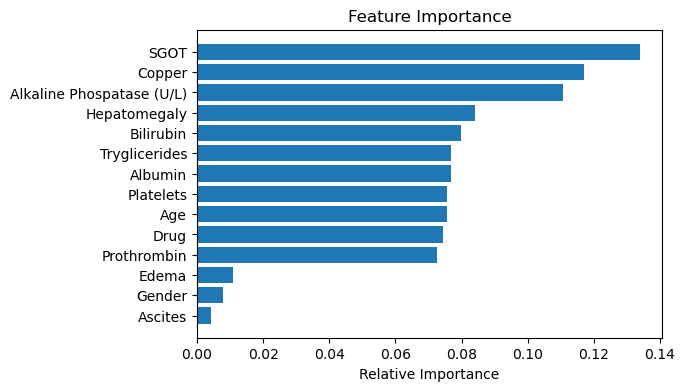

In [116]:
importances_rf = randomForest.feature_importances_
indices_rf = importances_rf.argsort()

plt.figure(figsize=(6,4))
plt.title("Feature Importance")
plt.barh(range(len(importances_rf)), importances_rf[indices_rf], align="center")
plt.yticks(range(len(importances_rf)), [x_train.columns[i] for i in indices_rf])
plt.xlabel("Relative Importance")
plt.show()

The top 5 most important features for the Random Forest model that have the strongest influence on predicting cirrhosis stages are SGOT, Copper, Alkaline Phospatase (U/L), Hepatomegaly, and Bilirubin. These 5 features allign with the clinical point of view below:
- SGOT: high SGOT levels are often associated with advanced liver disease
- Copper: elevated copper indicates there is liver dysfunction and damage
- Alkaline Phospatase (U/L): Alkaline Phospatase helps detect bile duct obstruction, cholestasis, and liver damage
- Hepatomegaly: the presence and degree of hepatomegaly (liver enlargement) are significant for assessing the severity of liver damage and staging cirrhosis
- Bilirubin: elevated bilirubin levels are often seen in advanced cirrhosis and liver failure

By using these features, the model can effectively differentiate between stages of cirrhosis based on clinical parameters.